# 1. pipeline函数

- pipeline()函数是Transformers库的核心接口，它封装了完整的模型推理流程，包括：
    - 预处理（分词、编码）
    - 模型推理
    - 后处理（解码、格式化）

## 1.1. pipeline函数原型定义与参数说明

```python
def pipeline(
    task: str | None = None,
    model: str | PreTrainedModel | None = None,
    config: str | PreTrainedConfig | None = None,
    tokenizer: str | PreTrainedTokenizer | PreTrainedTokenizerFast | None = None,
    feature_extractor: str | PreTrainedFeatureExtractor | None = None,
    image_processor: str | BaseImageProcessor | None = None,
    processor: str | ProcessorMixin | None = None,
    revision: str | None = None,
    use_fast: bool = True,
    token: str | bool | None = None,
    device: int | str | torch.device | None = None,
    device_map: str | dict[str, int | str] | None = None,
    dtype: str | torch.dtype | None = "auto",
    trust_remote_code: bool | None = None,
    model_kwargs: dict[str, Any] | None = None,
    pipeline_class: Any | None = None,
    **kwargs: Any,
) -> Pipeline:
```

- pipeline函数的返回的是Pipeline对象，实际返回的对象根据task任务，返回具体不同的Pipeline子类化对象。

### (1) 任务相关的参数-task

- task参数是pipeline函数唯一的必须的参数，用来指定要执行的NLP任务类型。
    - 任务包含：文本任务（Natural Language Processing），视觉任务（Computer Vision），多模态任务（Multimodal），音频任务（Audio）。
    - 具体的任务可以从官方文档获取
        - `https://hf-mirror.com/tasks`
        - 其他还有强化学习（Reinforcement Learning）与表格（Tabular）
        - 下面各个任务的模型数据截止2026年2月1日，模型的数量数据未来会有变化。

- 多模态任务（Multimodal）
    - Any-to-Any(11,735 models)
    - Audio-Text-to-Text(164 models)
    - Document Question Answering(239 models)
    - Visual Document Retrieval(124 models)
    - Image-Text-to-Text(7,322 models)
    - Image-Text-to-Image(38 models)
    - Image-Text-to-Video(7 models)
    - Video-Text-to-Text(264 models)
    - Visual Question Answering(544 models)

- 文本任务(Natural Language Processing)
    - Feature Extraction(15,832 models)
    - Fill-Mask(16,131 models)
    - Question Answering(13,552 models)
    - Sentence Similarity(14,029 models)
    - Summarization(2,607 models)
    - Table Question Answering(173 models)
    - Text Classification(109,851 models)
    - Text Generation(321,376 models)
    - Text Ranking(791 models)

- 视觉任务(Computer Vision)
    - Depth Estimation(271 models)
    - Image Classification(21,146 models)
    - Image Feature Extraction(970 models)
    - Image Segmentation(2,148 models)
    - Image-to-Image(2,046 models)
    - Image-to-Text(13,244 models)
    - Image-to-Video(561 models)
    - Keypoint Detection(150 models)
    - Mask Generation(186 models)
    - Object Detection(4,335 models
    - Video Classification(2,032 models)
    - Text-to-Image(91,201 models)
    - Text-to-Video(942 models)
    - Unconditional Image Generation(2,424 models)
    - Video-to-Video(83 models)
    - Zero-Shot Image Classification(1,107 models)
    - Zero-Shot Object Detection(99 models)
    - Text-to-3D(102 models)
    - Image-to-3D(392 models)

- 音频任务(Audio)
    - Audio Classification(3,854 models)
    - Audio-to-Audio(906 models)
    - Automatic Speech Recognition(27,846 models)
    - Text-to-Speech(3,996 models)

- 表格任务(Tabular)
    - Tabular Classification(436 models)
    - Tabular Regression(249 models)

- 强化学习任务(Reinforcement Learning)
    - Reinforcement Learning(69,216 models)

In [9]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis") # 第一次会自动下载
result = classifier("I loved Star Wars so much!")
##  [{'label': 'POSITIVE', 'score': 0.99}
print("-"*80)
print(result)
print("-"*80)
print(F"sentiment-analysis任务的默认模型是：{classifier.model.name_or_path}")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://hf-mirror.com/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


--------------------------------------------------------------------------------
[{'label': 'POSITIVE', 'score': 0.999840259552002}]
--------------------------------------------------------------------------------
sentiment-analysis任务的默认模型是：distilbert/distilbert-base-uncased-finetuned-sst-2-english


- 代码说明：
    - 当指定task的时候，没有指定model，代码运行会输出提示：
        - `No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://hf-mirror.com/distilbert/distilbert-base-uncased-finetuned-sst-2-english).`
        - `Using a pipeline without specifying a model name and revision in production is not recommended.`

- transformers的模型下载缓冲目录存放在TRANSFORMERS_CACHE变量中。

In [4]:
import os
from transformers import AutoModel, AutoTokenizer

# 查看默认缓存目录
from transformers.utils.hub import TRANSFORMERS_CACHE
print(f"Transformers默认缓存目录: {TRANSFORMERS_CACHE}")
print(f"目录存在: {os.path.exists(TRANSFORMERS_CACHE)}")

Transformers默认缓存目录: C:\Users\ThinkPad\.cache\huggingface\hub
目录存在: True


### (2) 任务相关的参数-model

- model参数是可选的，用于指定要使用的预训练模型。
    - model可以指定在线模型，或者下载到本地的模型。
    - 指定在线模型，只需要指定模型名字（在平台上的名字, 作者/模型名，比如`moonshotai/Kimi-K2.5`）
    - model参数默认是由任务指定的默认模型。每一类任务都有很多模型，但是都只有一个默认模型。

- 下面是对模型下载信息的管理

In [8]:
from transformers import pipeline
import os
import shutil
import platform

def get_os_specific_cache():
    """获取不同操作系统的默认缓存路径"""
    system = platform.system()
    
    if system == "Linux":
        # Linux: 通常是 ~/.cache/huggingface/hub
        base_dir = os.environ.get("XDG_CACHE_HOME", os.path.expanduser("~/.cache"))
        return os.path.join(base_dir, "huggingface", "hub")
    
    elif system == "Darwin":  # macOS
        # macOS: ~/Library/Caches/huggingface/hub
        return os.path.expanduser("~/Library/Caches/huggingface/hub")
    
    elif system == "Windows":
        # Windows: C:\Users\<username>\.cache\huggingface\hub
        appdata = os.environ.get("LOCALAPPDATA", os.path.expanduser("~"))
        return os.path.join(appdata, ".cache", "huggingface", "hub")
    
    else:
        return os.path.expanduser("~/.cache/huggingface/hub")
        
def download_and_analyze_model(model_name="distilbert-base-uncased"):
    """下载模型并分析缓存结构"""
    print(f"\n开始下载模型: {model_name}")
    
    # 记录下载前的缓存大小
    cache_dir = get_os_specific_cache()
    if os.path.exists(cache_dir):
        before_size = sum(os.path.getsize(os.path.join(dirpath, filename))
                         for dirpath, dirnames, filenames in os.walk(cache_dir)
                         for filename in filenames) / (1024*1024)
        print(f"下载前缓存大小: {before_size:.2f} MB")
    else:
        print("缓存目录不存在")
    
    # 下载模型
    print("正在下载模型...")   # 第一次才下载模型。
    pipe = pipeline("sentiment-analysis", model=model_name)
    
    # 获取模型的实际缓存路径
    model_path = pipe.model.name_or_path
    print(f"模型加载路径: {model_path}")
    
    # 检查是否为本地路径
    if os.path.exists(model_path):
        print(f"模型加载自本地: {model_path}")
    else:
        print("模型从缓存加载")
    
    # 下载后的缓存大小
    if os.path.exists(cache_dir):
        after_size = sum(os.path.getsize(os.path.join(dirpath, filename))
                        for dirpath, dirnames, filenames in os.walk(cache_dir)
                        for filename in filenames) / (1024*1024)
        print(f"下载后缓存大小: {after_size:.2f} MB")
        print(f"本次下载大小: {after_size - before_size:.2f} MB")
    
    return pipe

# 测试下载
model_pipe = download_and_analyze_model()


开始下载模型: distilbert-base-uncased
缓存目录不存在
正在下载模型...


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

C:\Program Files\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ThinkPad\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

模型加载路径: distilbert-base-uncased
模型从缓存加载


- 代码说明：
    - 上面代码运行输出的警告解释如下：
        - `C:\Program Files\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: 用户警告：`huggingface_hub`缓存系统默认使用符号链接来高效存储重复文件，但您的计算机在C:\Users\ThinkPad\.cache\huggingface\hub\models--distilbert-base-uncased中不支持符号链接。缓存文件仍然可以工作，但会以降级版本运行，可能需要在您的磁盘上占用更多空间。可以通过设置`HF_HUB_DISABLE_SYMLINKS_WARNING`环境变量来禁用此警告。有关更多详细信息，请参阅https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations。要在Windows上支持符号链接，您需要激活开发者模式或以管理员身份运行Python。要激活开发者模式，请参阅以下文章：https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development`
        - `“DistilBertForSequenceClassification 的部分权重未从 distilbert-base-uncased 模型检查点初始化，这些权重是新初始化的：['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']。建议在下游任务上训练该模型，以便用于预测和推理。”`
    - model的默认下载与加载不是单纯的下载到本地并加载，而是使用缓存加载模式，其下载的模型与目录的名字有细微改变。下面是在Window下同的缓冲目录

```python
├─models--distilbert-base-uncased
│  ├─.no_exist
│  │  └─12040accade4e8a0f71eabdb258fecc2e7e948be
│  │          added_tokens.json
│  │          special_tokens_map.json
│  │
│  ├─blobs
│  ├─refs
│  │      main
│  │
│  └─snapshots
│      └─12040accade4e8a0f71eabdb258fecc2e7e948be
│              config.json
│              model.safetensors
│              tokenizer.json
│              tokenizer_config.json
│              vocab.txt
│
```

- 下面使用下载到本地的加载模式。
    - 我们选择了文本任务中的翻译任务，并且选择其中的一个模型：``
        - 下载地址，我们选择国内下载速度较快的站点（魔塔）：`git clone https://www.modelscope.cn/facebook/nllb-200-1.3B.git`

- 下载文件清单如下；
```python
F:\03MODELS\NLLB-200-1.3B
    .gitattributes
    config.json
    configuration.json
    generation_config.json
    pytorch_model.bin
    README.md
    sentencepiece.bpe.model
    special_tokens_map.json
    tokenizer.json
    tokenizer_config.json
```

In [16]:
# 警告： Pipeline type "translation" is no longer supported in transformers v5.
# 安装5.0以下版本
# 'pip install "transformers<5.0.0'
from transformers import pipeline

pipe = pipeline("translation", model="F:/03MODELS/NLLB-200-1.3B", src_lang="eng_Latn", tgt_lang="zho_Hans")
print(pipe)
pipe('how are you.')

[{'translation_text': '您好,您好.'}]

- 代码说明：
    - 关于pipeline函数的参数（src_lang参数与tgt_lang参数是翻译任务的特定参数）还与实际的任务有关，后面对争对特定的任务的参数，再详细讲解这些参数，这里只介绍pipeline函数的通用参数。

### (3) 任务相关的参数-config

- config参数是可选的，用于指定或自定义模型的配置，配置包含：
    - 模型架构参数（层数、隐藏层大小等）
    - 模型任务特定配置（分类标签数等）
    - 推理和训练行为
    - 预训练模型的配置覆盖

- 一般我们使用config参数是为了修改原始配置，不建议手工构造一个配置，所以一般操作是：
    - 先加载原始配置，然后修改。

- 我们继续使用默认翻译任务的模型来说明（NLLB-200-1.3B）：
    - NLLB（No Language Left Behind）是Meta开发的多语言翻译模型：
        - 支持200种语言间的互译
        - 1.3B参数版本在质量和效率间取得平衡
        - 基于Transformer编码器-解码器架构
        - 专门优化的多语言词表

In [19]:
from transformers import AutoConfig, pipeline

# 查看NLLB-200-1.3B的默认配置
config = AutoConfig.from_pretrained("F:/03MODELS/NLLB-200-1.3B")

print("=" * 80)
print("NLLB-200-1.3B 配置概览")
print("=" * 80)

# 基本信息
print(f"模型类型: {config.model_type}")
print(f"架构类型: {'编码器-解码器' if config.is_encoder_decoder else '其他'}")
print(f"参数数量: ~{config.vocab_size:,} 词汇表 + {config.d_model:,}×{config.encoder_layers}层")

# 核心架构参数
print("\n★核心架构参数:")
print(f"  |-d_model (隐藏维度): {config.d_model}")
print(f"  |-编码器层数: {config.encoder_layers}")
print(f"  |-解码器层数: {config.decoder_layers}")
print(f"  |-注意力头数: {config.encoder_attention_heads}")
print(f"  |-FFN中间层维度: {config.encoder_ffn_dim}")
print(f"  |-词表大小: {config.vocab_size:,}")

# 多语言相关
print("\n★多语言配置:")
print(f"  |-语言数量: 200+")
print(f"  |-默认源语言: {getattr(config, 'src_lang', '未指定')}")
print(f"  |-默认目标语言: {getattr(config, 'tgt_lang', '未指定')}")
print(f"  |-语言标记数量: {getattr(config, 'lang_tokens', 'N/A')}")

# 解码配置
print("\n★解码配置:")
print(f"  |-解码开始标记: {config.decoder_start_token_id}")
print(f"  |-强制结束标记: {config.forced_eos_token_id}")
print(f"  |-最大位置编码: {config.max_position_embeddings}")
print(f"  |-初始化范围: {config.init_std}")

# transformers框架的版本配置
print("\n★Transformers框架配置:")
print(f"  |-版本: {config.transformers_version}")


# 将配置保存为JSON以便详细查看
import json
config_dict = config.to_dict()
with open("nllb_config.json", "w", encoding="utf-8") as f:
    json.dump(config_dict, f, indent=2, ensure_ascii=False)
print(f"\n详细配置已保存到: nllb_config.json")

NLLB-200-1.3B 配置概览
模型类型: m2m_100
架构类型: 编码器-解码器
参数数量: ~256,206 词汇表 + 1,024×24层

★核心架构参数:
  |-d_model (隐藏维度): 1024
  |-编码器层数: 24
  |-解码器层数: 24
  |-注意力头数: 16
  |-FFN中间层维度: 8192
  |-词表大小: 256,206

★多语言配置:
  |-语言数量: 200+
  |-默认源语言: 未指定
  |-默认目标语言: 未指定
  |-语言标记数量: N/A

★解码配置:
  |-解码开始标记: 2
  |-强制结束标记: None
  |-最大位置编码: 1024
  |-初始化范围: 0.02

★Transformers框架配置:
  |-版本: 4.21.0.dev0

详细配置已保存到: nllb_config.json


- 代码说明；
    - 如果需要完全明白config中的配置，需要对模型的充分理解。我们这里不详细解释这些配置，但是需要掌握怎么修改这些配置。
    - AutoConfig.from_pretrained实际返回的配置数据比配置文件中的数据要更加详细，一般配置文件三个：
        - config.json
        - generation_config.json
        - configuration.json（不加载）

- 修改config配置的应用

In [24]:
# 警告： Pipeline type "translation" is no longer supported in transformers v5.
# 安装5.0以下版本
# 'pip install "transformers<5.0.0'
from transformers import AutoConfig, pipeline
config = AutoConfig.from_pretrained("F:/03MODELS/NLLB-200-1.3B")
        
# 推理优化配置
config.update({
    "use_cache": True,           # 启用KV缓存加速
    "output_attentions": False,  # 不输出注意力权重
    "output_hidden_states": False,  # 不输出隐藏状态
    "return_dict_in_generate": True,  # 生成时返回字典
    "forced_eos_token_id": 2,    # 结束标记
    "early_stopping": True,      # 启用提前停止
    "num_beams": 4,              # beam search束宽
    "length_penalty": 1.0,       # 长度惩罚
})

pipe = pipeline("translation", model="F:/03MODELS/NLLB-200-1.3B", config=config)
src = "Information about training algorithms, parameters, fairness constraints or other applied approaches, and features. The exact training algorithm, data and the strategies to handle data imbalances for high and low resource languages that were used to train NLLB-200 is described in the paper."
pipe(src, src_lang="eng_Latn", tgt_lang="zho_Hans")

[{'translation_text': '关于培训算法,参数,公平性约束或其他应用方法和特征的信息.该论文描述了用于培训NLLB-200的高和低资源语言的确切培训算法,数据和处理数据失衡的策略.'}]

- 代码说明：
    - 修改配置参数，可以优化模型的推理性能。并且在不同的应用场景，需要不同的配置参数，比如翻译场景下，可能对max_length的值有不同要求，以及翻译准确度的要求。

### (4) 预处理组件参数-tokenizer 

- 在Transformers框架中，pipeline函数的tokenizer参数用于指定自定义的分词器，这在以下场景中特别有用：
    - **使用预训练模型的自定义分词器**：当pipeline默认加载的分词器不匹配时
    - **使用本地保存的分词器**：从本地文件加载分词器配置
    - **修改分词器参数**：调整如填充、截断等参数
    - **性能优化**：重用已加载的分词器实例

- 因为下载模型的时候就带原生的分词器，所以大部分的应用还是修改分词器参数居多。

In [28]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

# 加载分词器并自定义配置
tokenizer = AutoTokenizer.from_pretrained(
    "F:/03MODELS/NLLB-200-1.3B",
    padding="max_length",  # 填充到最大长度
    max_length=128,       # 最大序列长度
    truncation=True       # 启用截断
)

# 创建pipeline时传入自定义分词器
translator = pipeline(
    "translation",
    model="F:/03MODELS/NLLB-200-1.3B",
    tokenizer=tokenizer,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

# 示例翻译
print(translator("What is your name?", src_lang="eng_Latn", tgt_lang="zho_Hans", num_beams=4))
print(translator("What is your name?", src_lang="eng_Latn", tgt_lang="zho_Hant", num_beams=4))

[{'translation_text': '你的名字是什么?'}]
[{'translation_text': '你的名字是什麼?'}]


- 代码说明：
    - 代码中支持的语言代码名，可以从"special_tokens_map.json"文件中获取所有清单。
        - eng_Latn：拉丁英语
        - zho_Hans：简体中文
        - zho_Hans：繁体中文
    - 代码中我们使用了GPU（如果电脑支持硬件，并且PyTorch也是GPU版本）
    - 使用自定制的分词器，可以设置定制的分词器参数。

### (5) 预处理组件参数-feature_extractor/image_processor

- 在Transformers框架中，feature_extractor参数主要用于处理音频和语音任务，也用于某些多模态模型。其主要目的：
    - **音频特征提取**：将原始音频波形转换为模型可处理的频谱特征
    - **预处理控制**：自定义音频的采样率、长度、归一化等参数
    - **批处理优化**：配置padding等参数以支持批量音频处理
    - **与特定模型匹配**：确保特征提取方式与模型训练时一致

- 我们使用`automatic-speech-recognition`任务中的`openai/whisper-large-v3`大模型。
    - 为了下载方便，我们还是在魔塔中搜索到，然后下载:`git clone https://www.modelscope.cn/openai-mirror/whisper-large-v3.git`
    - 在下载的大模型文件中，在`preprocessor_config.json`文件就是`feature_extractor`的配置。

```python
F:\03MODELS\WHISPER-LARGE-V3
    .gitattributes
    added_tokens.json
    config.json
    configuration.json
    flax_model.msgpack
    generation_config.json
    merges.txt
    model.fp32-00001-of-00002.safetensors
    model.fp32-00002-of-00002.safetensors
    model.safetensors
    model.safetensors.index.fp32.json
    normalizer.json
    preprocessor_config.json
    pytorch_model.bin
    pytorch_model.bin.index.fp32.json
    pytorch_model.fp32-00001-of-00002.bin
    pytorch_model.fp32-00002-of-00002.bin
    README.md
    special_tokens_map.json
    tokenizer.json
    tokenizer_config.json
    vocab.json
```

- feature_extractor参数读取的配置文件信息。 

```python
{
  "chunk_length": 30,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 128,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}

```

In [1]:
from transformers import pipeline, AutoFeatureExtractor, AutoModelForSpeechSeq2Seq
import torch

# 步骤1：加载自定义feature_extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(
    "F:/03Models/whisper-large-v3",
    sampling_rate=16000,   # 采样率
    do_normalize=True,     # 归一化
    return_attention_mask=True,
    padding=True,
    max_length=30000  # 最大音频长度
)
print(feature_extractor)
# 步骤2：创建pipeline并传入feature_extractor
asr_pipeline = pipeline(
    "automatic-speech-recognition",
    model="F:/03Models/whisper-large-v3",
    feature_extractor=feature_extractor,  # 关键：传入自定义特征提取器
    tokenizer="F:/03Models/whisper-large-v3",  # 还需要tokenizer
    device="cuda" if torch.cuda.is_available() else "cpu",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)
print("ASR pipeline已创建，使用自定义feature_extractor")
print(asr_pipeline("./sounds/A2_58.wav"))

WhisperFeatureExtractor {
  "chunk_length": 30,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 128,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": true,
  "sampling_rate": 16000
}



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


ASR pipeline已创建，使用自定义feature_extractor


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


{'text': '特别是跨省区电网,超计划用电不仅损害自己,也损害别人,损害电网,损害国家。'}


- 代码说明：
    - 代码中仅仅展示feature_extractor参数的使用方式，在这里不详细讲解WhisperFeatureExtractor对象的加载与参数使用。
    - 代码实现的功能是把语音文件转换为文本（语音识别）。

### (6) 预处理组件参数-image_processor

- image_processor参数专门用于视觉模型的图像预处理。image_processor参数的主要作用：
    - **图像标准化**：调整图像大小、归一化、颜色空间转换
    - **数据增强**：裁剪、翻转、旋转等预处理
    - **格式转换**：转换为模型所需的张量格式
    - **批处理支持**：处理多个图像，统一尺寸 

- image_processor的核心功能：（下面功能的使用，可以参考后面代码中的使用）
    - 图像调整：do_resize, size, resample
    - 裁剪处理：do_center_crop, crop_size
    - 颜色处理：do_convert_rgb, do_convert_grayscale
    - 归一化：do_normalize, image_mean, image_std
    - 批处理：do_pad, padding, padding_value

- 我们使用YOLO（yolos-tiny）模型，YOLOS-Tiny是YOLOS（You Only Look at One Sequence）模型的轻量化版本，其核心作用是用端到端的方式直接从图像中检测并定位多个物体。其功能如下：
    - **目标检测**：在图像中识别并定位多个物体，输出每个物体的边界框（Bounding Box）、类别标签和置信度分数。
    - **实时检测**：由于“Tiny”轻量化设计，相比大型检测模型，它能在资源受限的环境下实现更快的推理速度。
    - **端到端检测**：无需传统目标检测中的区域提议（如R-CNN系列）或锚框设计（如YOLOv3-v5），直接从输入到输出。

- 我们依然从魔塔下载模型文件：
    - `git clone https://www.modelscope.cn/hustvl/yolos-tiny.git`


检测到 20 个对象:
- person: 0.992, 位置: [1532, 1895, 1656, 2293]
- person: 0.994, 位置: [667, 1845, 887, 2494]
- person: 0.918, 位置: [1699, 1899, 1800, 2260]
- car: 0.939, 位置: [122, 1813, 273, 1926]
- traffic light: 0.991, 位置: [207, 865, 281, 1063]
- person: 0.989, 位置: [2, 2075, 780, 2712]
- person: 0.961, 位置: [276, 1874, 432, 2143]
- traffic light: 0.990, 位置: [1135, 1488, 1197, 1642]
- traffic light: 0.967, 位置: [1179, 1272, 1254, 1614]
- person: 0.972, 位置: [1351, 1886, 1456, 2216]
- person: 0.927, 位置: [72, 1920, 251, 2253]
- bicycle: 0.957, 位置: [587, 2121, 700, 2355]
- traffic light: 0.956, 位置: [1180, 1271, 1244, 1506]
- person: 0.902, 位置: [2, 1905, 235, 2455]
- person: 0.951, 位置: [1429, 1861, 1527, 2205]
- traffic light: 0.998, 位置: [543, 880, 615, 1080]
- person: 0.959, 位置: [1729, 1891, 1840, 2271]
- car: 0.931, 位置: [597, 1807, 684, 1885]
- person: 0.920, 位置: [572, 1845, 713, 2195]
- person: 0.953, 位置: [916, 1840, 980, 2063]


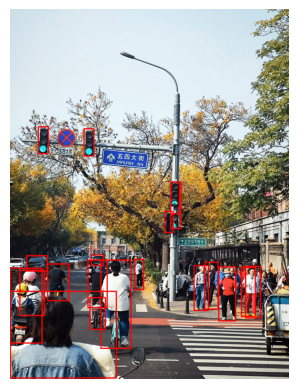

In [5]:
from transformers import pipeline, AutoImageProcessor
import cv2
import matplotlib.pyplot as plt

# 创建自定义image_processor
image_processor = AutoImageProcessor.from_pretrained(
    "F:/03Models/yolos-tiny",
    do_resize=True,
    size=640,
    do_normalize=True,
    pad_and_return_pixel_mask=True,  # 目标检测需要像素掩码
    do_center_crop=True,
    crop_size=640
)

# 目标检测pipeline
detector = pipeline(
    "object-detection",
    model="F:/03Models/yolos-tiny",
    image_processor=image_processor,  # 传入自定义处理器
    device=0  # 0:GPU, -1:CPU
)

# 运行检测
img = cv2.imread("./imgs/street.jpg", cv2.IMREAD_COLOR_RGB)
detections = detector("./imgs/street.jpg")
print(f"\n检测到 {len(detections)} 个对象:")
for detection in detections:
    box = detection['box']
    print(f"- {detection['label']}: {detection['score']:.3f}, "
          f"位置: [{box['xmin']:.0f}, {box['ymin']:.0f}, {box['xmax']:.0f}, {box['ymax']:.0f}]")
    cv2.rectangle(img, pt1=(box['xmin'], box['ymin']), pt2=(box['xmax'], box['ymax']), color=(255, 0, 0), thickness=8)

plt.imshow(img)
plt.axis(False)
plt.show()

- 代码说明：
    - 在大部分情况下，我们都使用模型中自带的图像处理器，在特殊需要下，我们可以加载image_processor，并定制特殊的参数。
    - 代码中主要侦测目标，并且打印与标注目标。

### (7) 预处理组件参数-processor

- 在Transformers框架中，processor参数是多模态模型的统一处理器，它封装了多个预处理组件。processor参数的主要作用：
    - 多模态处理：统一处理图像+文本、音频+文本等多模态输入
    - 组件整合：封装tokenizer、feature_extractor、image_processor等
    - 简化API：提供统一的预处理接口
    - 保证一致性：确保所有模态的预处理与模型训练时一致

- 下面我们使用blip-image-captioning-base模型，这是个图像描述生成大模型。其核心作用是理解图像内容并用自然语言生成准确、连贯的描述（俗称看图说话或者望图生义）。
    - 我们依然在魔塔站点下载：`git clone https://www.modelscope.cn/Salesforce/blip-image-captioning-base.git`

In [14]:
from transformers import pipeline, AutoProcessor
from PIL import Image

# 加载BLIP processor（统一处理图像和文本）
blip_processor = AutoProcessor.from_pretrained(
    "F:/03Models/blip-image-captioning-base",
    padding=True,
    truncation=True,
    max_length=50
)
print(blip_processor)
# 创建图像描述pipeline
caption_pipe = pipeline(
    "image-to-text",
    model="F:/03Models/blip-image-captioning-base",
    # processor="F:/03Models/blip-image-captioning-base",  # 传入processor而不是单独的tokenizer和image_processor
    device=-1
)

# 处理图像
result = caption_pipe("./imgs/scene.jpg", max_new_tokens=50)
print(f"图像描述: {result}")

BlipProcessor:
- image_processor: BlipImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "do_convert_rgb",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "BlipImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "BlipProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

- tokenizer: BertTokenizerFast(name_or_path='F:/03Models/blip-image-captioning-base', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[

- 代码说明：
    - processor参数只有transformers5.0以后版本支持，在当前版本4.39.3。（在5.0版本以上，可以把代码中注释的processor参数取消运行），在5.0版本中对处理器提供了更加精细的处理。
    - 从上面processor对象的输出可以看出，processor参数提供image_processor与tokenizer等更加方便的统一处理。

### (8) 框架与设备参数-framework/torch_dtype 

- framework参数指定使用哪个深度学习框架来运行模型，主要指定两种框架pytorch与tesorflow，简写为"pt"与"tf"
    - 该参数在未来新的transformers框架中不再支持。
    - 大部分情况下载模型中可以自动识别。

- torch_dtype参数控制PyTorch模型使用的数据类型，主要用于内存优化和加速。
    - 参数取值：torch.float16`, `torch.bfloat16`, ... `"auto"等 

### (9) 框架与设备参数-device/device_map

- device参数用来指定运算处理器设备,取值包含三种类型：
    - `int`：0表示GPU，-1表示cpu。
    - `str`：比如"cuda"，"cpu"，"cuda:0"（0表示GPU索引，当有多个GPU可以指定）
    - `torch.device`对象。

- device_map参数用于在多GPU或混合设备上分布式加载大型模型，在多个GPU的情况下使用才有意义。下面是一个简单的例子（因为测试机器只有一个GPU，所以例子不能运行，只能展示其使用方式）

```python
from transformers import pipeline
import torch

# 显式指定不同层到不同设备
device_map = {
    "transformer.wte": 0,           # 词嵌入层 -> GPU 0
    "transformer.wpe": 0,           # 位置嵌入层 -> GPU 0
    "transformer.h.0": 0,           # 第1个Transformer层 -> GPU 0
    "transformer.h.1": 0,
    "transformer.h.2": 0,
    "transformer.h.3": 0,
    "transformer.h.4": 1,           # 第5个Transformer层 -> GPU 1
    "transformer.h.5": 1,
    "transformer.h.6": 1,
    "transformer.h.7": 1,
    "transformer.h.8": "cpu",       # 第9个Transformer层 -> CPU
    "transformer.h.9": "cpu",
    "transformer.h.10": 2,          # 第11个Transformer层 -> GPU 2
    "transformer.h.11": 2,
    "transformer.ln_f": 2,          # 层归一化 -> GPU 2
    "lm_head": 2                    # 输出层 -> GPU 2
}

if torch.cuda.device_count() >= 3:
    text_generator = pipeline(
        "text-generation",
        model="gpt2-medium",
        device_map=device_map,  # 使用自定义设备映射
        torch_dtype=torch.float16,
        max_new_tokens=50
    )
    print("使用自定义device_map的pipeline已创建")
```

- 代码说明：
    - 使用device_map需要对模型的权重层有深入的了解。
    - 该参数字符串还有其他取值如下：
        - "auto"：自动平衡分布到所有可用设备
        - "balanced"：平衡内存使用
        - "sequential"：按顺序分布到设备
        - "cpu"：全部放在CPU
        - "disk"：使用磁盘卸载

### (10) 模型加载参数-revision/use_fast/trust_remote_code 

- revision参数用于指定要加载的模型版本（提交哈希、分支名或标签），默认是main分支，这个参数只对在线大模型文件有效。使用git下载，可以使用checkout拉取指定分支、哈希与标签。在下载页面和可以看到分支或者哈希码。

- use_fast参数用于控制是否使用Rust编写的快速分词器（来自tokenizers库），参数类型bool类型。
    - use_fast参数为True，使用快速分词器比纯Python分词器快2-10倍。

- 下面代码说明yse_fast的使用，也说明其对分词性能的优化。

In [21]:
from transformers import pipeline, AutoTokenizer
import time

text = "Hello, I'm learning about Transformers pipeline parameters. " * 40  # 重复10次增加长度

# 测试慢速分词器
print("测试慢速分词器 (use_fast=False)...")
start_time = time.time()
tokenizer_slow = AutoTokenizer.from_pretrained(
    "F:/03Models/bert-base-uncased",
    use_fast=False  # 使用Python实现的慢速分词器
)
slow_tokens = tokenizer_slow(text, return_tensors="pt")
slow_time = time.time() - start_time
print(f"慢速分词器耗时: {slow_time:.4f}秒")
print(f"分词数量: {len(slow_tokens['input_ids'][0])}")

# 测试快速分词器
print("\n测试快速分词器 (use_fast=True)...")
start_time = time.time()
tokenizer_fast = AutoTokenizer.from_pretrained(
    "F:/03Models/bert-base-uncased",
    use_fast=True  # 使用Rust实现的快速分词器（默认）
)
fast_tokens = tokenizer_fast(text, return_tensors="pt")
fast_time = time.time() - start_time
print(f"快速分词器耗时: {fast_time:.4f}秒")
print(f"分词数量: {len(fast_tokens['input_ids'][0])}")

# 性能对比
speedup = slow_time / fast_time if fast_time > 0 else 0
print(f"\n性能提升: {speedup:.2f}x 更快")
print(f"时间节省: {(slow_time - fast_time)*1000:.1f}毫秒")

# 验证分词结果是否相同
print(f"\n分词结果相同: {slow_tokens['input_ids'].equal(fast_tokens['input_ids'])}")

测试慢速分词器 (use_fast=False)...
慢速分词器耗时: 0.0401秒
分词数量: 442

测试快速分词器 (use_fast=True)...
快速分词器耗时: 0.0287秒
分词数量: 442

性能提升: 1.40x 更快
时间节省: 11.4毫秒

分词结果相同: True


- trust_remote_code参数用于安全地加载和执行远程代码。其主要作用：
    - **安全加载**：控制是否信任并执行来自远程仓库的自定义代码
    - **模型兼容**：支持加载使用自定义架构的模型
    - **实验特性**：访问社区贡献的新模型架构
    - **安全边界**：防止潜在的恶意代码执行

- 这种情况是在下载的大模型代码中存在python代码，很多开源打大模型会提供python代码，在加载的时候可能需要加载。下面是DeeepSeek的大模型下载文件列表，其中就有python代码

```python
D:\DEEPSEEK\DEEPSEEK-CODER-V2-LITE-INSTRUCT
    .gitattributes
    config.json
    configuration.json
    configuration_deepseek.py
    generation_config.json
    model-00001-of-000004.safetensors
    model-00002-of-000004.safetensors
    model-00003-of-000004.safetensors
    model-00004-of-000004.safetensors
    model.safetensors.index.json
    modeling_deepseek.py
    README.md
    tokenization_deepseek_fast.py
    tokenizer.json
    tokenizer_config.json
```

### (11) 其他参数 

- 模型加载参数-model_kwargs
    - 可以传递AutoModle.from_pretrained函数中可以指定的参数。
    - 参数形式是一个字典形式来传递多个参数。

- 任务特定参数-kwargs 
    - pipeline会根据任务调用不同的XXXPipeline，这些类的参数可以通过这个参数kwargs 来传递
    - 参数形式是一个字典形式来传递多个参数。

- 管道特定参数-pipeline_class
    - 这个参数在transformers5.0中已经没有这个参数，代码中会根据任务自动判断Pipeline的类型，使用参数指定意义不大，也累赘，而且容易出问题。

### (12) Pipeline管道的构成

- 通过上面参数，我们大致可以了解协作Pipeline工作的对象有：
    - 输入预处理对象： tokenizer, image_processor, feature_extractor, processor。
    - 核心的model对象
    - 模型调用后的处理：processor也处理输出的处理。

## 1.2. Pipeline类与对象

- pipeline函数实际是一个工厂方法，是一个通过函数来创建Pipeline对象的函数。

- Pipeline类因为不同任务的差异性，所以每个任务的Pipeline会子类化。

### (1) Pipeline子类介绍 

- 音频Pipeline子类
    - AudioClassificationPipeline
    - AutomaticSpeechRecognitionPipeline
    - TextToAudioPipeline
    - ZeroShotAudioClassificationPipeline

- 视觉Pipeline子类
    - DepthEstimationPipeline
    - ImageClassificationPipeline
    - ImageSegmentationPipeline
    - ImageToImagePipeline
    - KeypointMatchingPipeline
    - ObjectDetectionPipeline
    - VideoClassificationPipeline
    - ZeroShotImageClassificationPipeline
    - ZeroShotObjectDetectionPipeline

- 多模态Pipeline子类
    - DocumentQuestionAnsweringPipeline
    - FeatureExtractionPipeline
    - ImageFeatureExtractionPipeline
    - ImageTextToTextPipeline
    - AnyToAnyPipeline
    - MaskGenerationPipeline
    - VisualQuestionAnsweringPipeline
   

- 文本(自然语言)Pipeline子类
    - FillMaskPipeline
    - QuestionAnsweringPipeline
    - TableQuestionAnsweringPipeline
    - TextClassificationPipeline
    - TextGenerationPipeline
    - TokenClassificationPipeline
    - ZeroShotClassificationPipeline

### (2) Pipeline类的使用

- Pipelinne的构造器如下，其参数在前面都有介绍。

```python
def __init__(
    self,
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer | None = None,
    feature_extractor: PreTrainedFeatureExtractor | None = None,
    image_processor: BaseImageProcessor | None = None,
    processor: ProcessorMixin | None = None,
    task: str = "",
    device: int | torch.device | None = None,
    binary_output: bool = False,
    **kwargs,
):
```

- 下面是Pipeline类图
    - 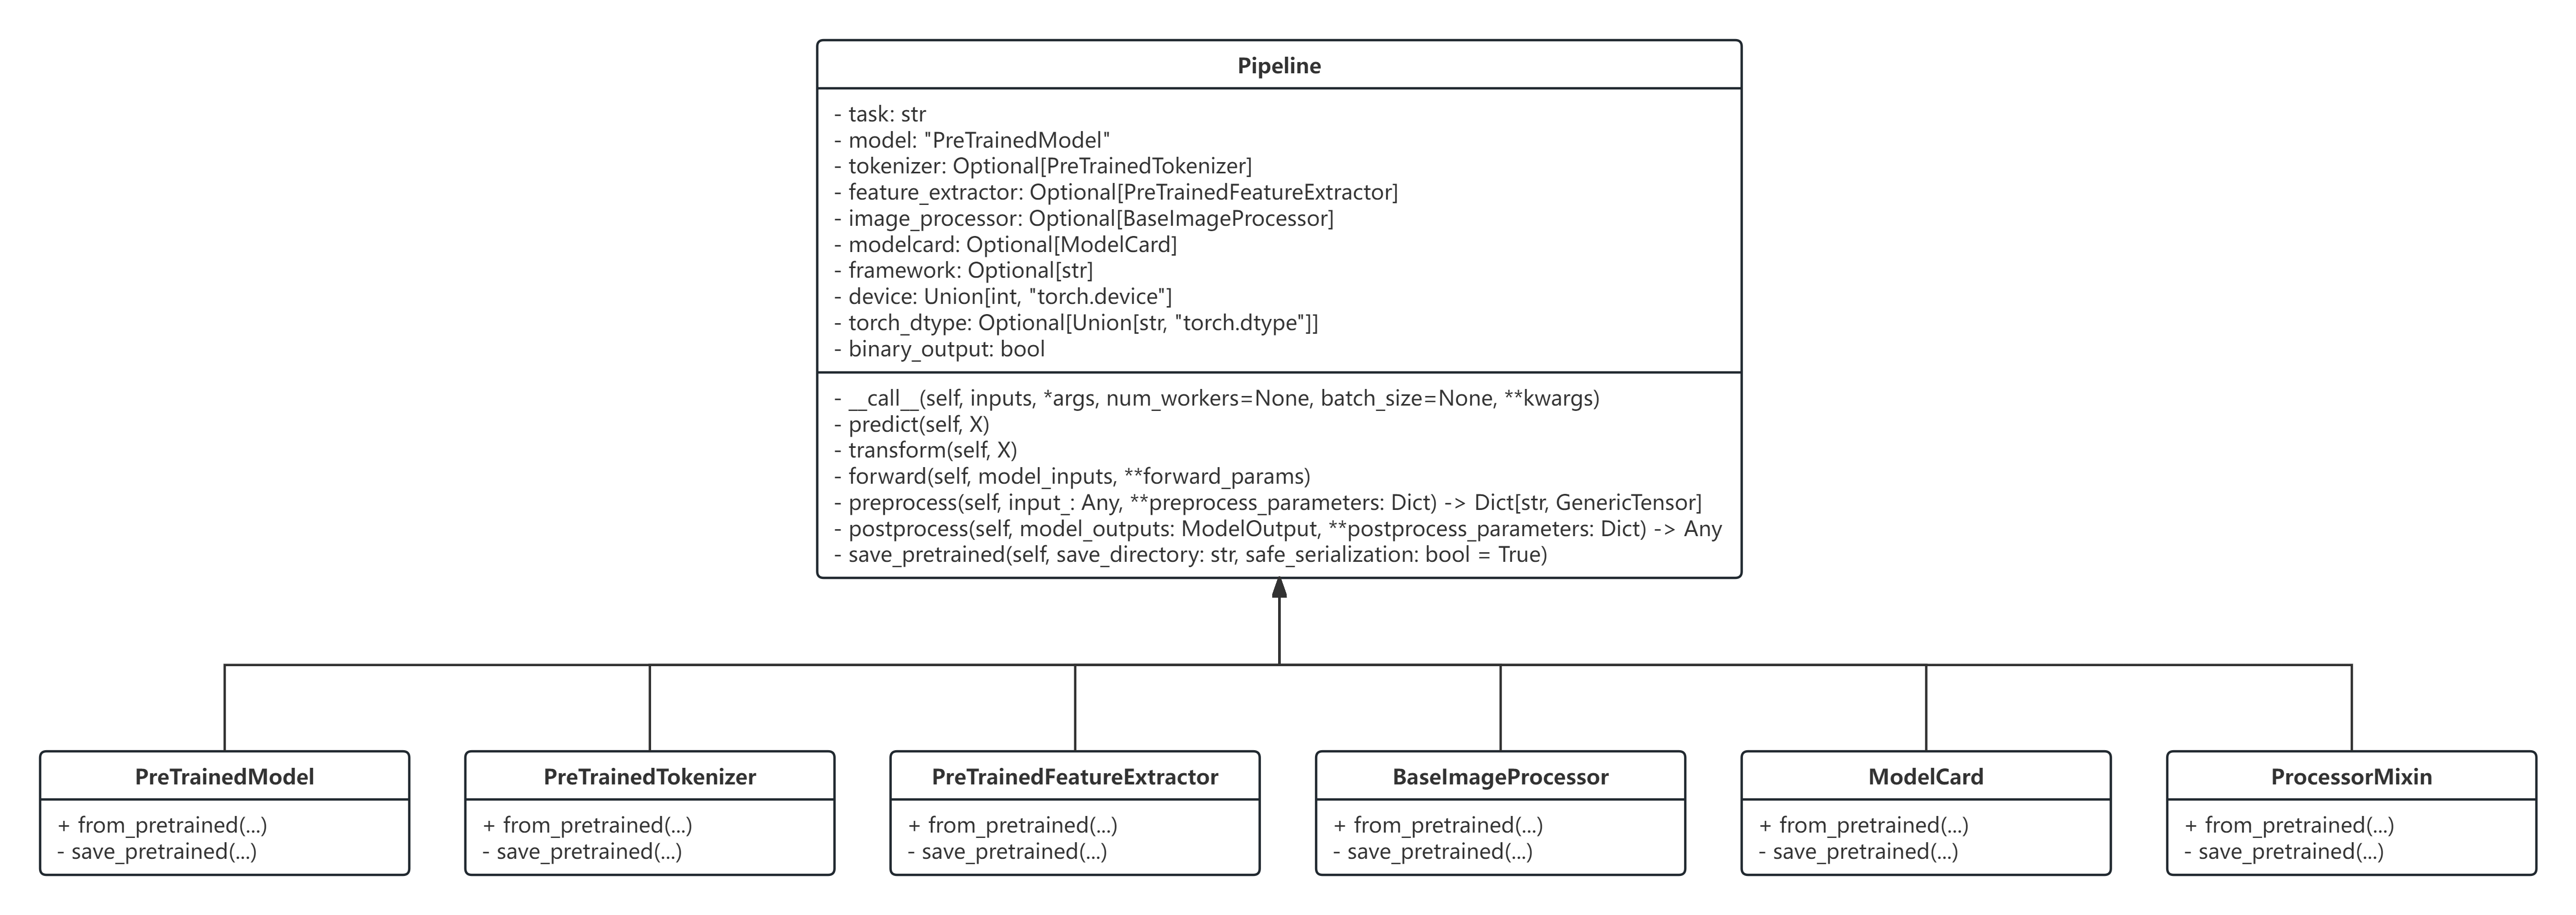

- Pipeline属性使用